In [2]:
import pandas as pd

#데이터 불러오기
brent_oil_prices=pd.read_csv('C:/Users/82106/Desktop/경영캡스톤/data2/preprocessed_BrentOilPrices.csv')
gold_prices=pd.read_csv('C:/Users/82106/Desktop/경영캡스톤/data2/preprocessed_gold.csv')
nasdaq_prices=pd.read_csv('C:/Users/82106/Desktop/경영캡스톤/data2/preprocessed_nasdaq.csv')

#첫 몇개 줄 출력
brent_oil_prices_head=brent_oil_prices.head()
gold_prices_head=gold_prices.head()
nasdaq_prices_head=nasdaq_prices.head()

(brent_oil_prices_head,gold_prices_head,nasdaq_prices_head)

(         Date  Price
 0  2000-01-04  23.95
 1  2000-01-05  23.72
 2  2000-01-06  23.55
 3  2000-01-07  23.35
 4  2000-01-10  22.77,
          Date   Open   High    Low  Close  Volume Currency
 0  2000-01-04  289.5  289.5  280.0  283.7   21621      USD
 1  2000-01-05  283.7  285.0  281.0  282.1   25448      USD
 2  2000-01-06  281.6  282.8  280.2  282.4   19055      USD
 3  2000-01-07  282.5  284.5  282.0  282.9   11266      USD
 4  2000-01-10  282.4  283.9  281.8  282.7   30603      USD,
          Date       Open       High        Low      Close  Adj Close    Volume
 0  2004-01-02  36.660000  36.790001  36.220001  36.360001  31.140272  55234100
 1  2004-01-05  36.580002  37.160000  36.560001  37.090000  31.765478  69717900
 2  2004-01-06  37.080002  37.419998  36.950001  37.340000  31.979589  60033000
 3  2004-01-07  37.279999  37.680000  37.070000  37.680000  32.270798  71830000
 4  2004-01-08  37.849998  38.000000  37.599998  37.980000  32.527729  76800900)

In [4]:
import numpy as np

#3가지 자산의 일일 수익률 계산

brent_oil_returns=brent_oil_prices['Price'].pct_change().apply(lambda x:np.log(1+x))
gold_returns=gold_prices['Close'].pct_change().apply(lambda x:np.log(1+x))
nasdaq_returns=nasdaq_prices['Close'].pct_change().apply(lambda x:np.log(1+x))

#수익률 조합 하기
combined_returns=pd.DataFrame({
    'BrentOil':brent_oil_returns,
    'Gold':gold_returns,
    'Nasdaq': nasdaq_returns
})

#결측치는 drop 하기
combined_returns=combined_returns.dropna()

#기대수익률(평균), 변동성(표준편차), 상관관계 행렬 계산
expected_returns=combined_returns.mean()*252 # 평균 수익률을 연간화
volatility=combined_returns.std()*np.sqrt(252)
correlation_matrix=combined_returns.corr()

(expected_returns,volatility, correlation_matrix)

(BrentOil    0.043992
 Gold        0.083845
 Nasdaq      0.117319
 dtype: float64,
 BrentOil    0.354582
 Gold        0.175150
 Nasdaq      0.215993
 dtype: float64,
           BrentOil      Gold    Nasdaq
 BrentOil  1.000000 -0.015060  0.003596
 Gold     -0.015060  1.000000 -0.003093
 Nasdaq    0.003596 -0.003093  1.000000)

In [7]:
from scipy.optimize import minimize

# 최적화 문제 정의
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def minimize_volatility(mean_returns, cov_matrix, return_target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # The sum of weights is 1
                   {'type': 'eq', 'fun': lambda x: np.dot(x, mean_returns) - return_target})  # Target return
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# 공분산 행렬 계산
cov_matrix = combined_returns.cov() * 252  # Annualize the covariance matrix

# 목표수익률을 자산의 기대수익률 평균으로 설정
target_return = expected_returns.mean()

# 최적화 수행(변동성 최소화)
min_vol_result = minimize_volatility(expected_returns, cov_matrix, target_return)

# 최적의 가중치 획득
optimal_weights = min_vol_result.x

optimal_weights, min_vol_result.fun


(array([0.22116197, 0.57905392, 0.19978411]), 0.1343717619757004)

In [8]:
# 효율적인 투자선을 찾을 수 있는 기능
def efficient_frontier(mean_returns, cov_matrix, return_range):
    efficient_portfolios = []
    for target in return_range:
        efficient_portfolios.append(minimize_volatility(mean_returns, cov_matrix, target))
    return efficient_portfolios

In [9]:
# 최소 예상 수익률과 최대 기대 수익률 사이의 목표 수익률 범위 생성
return_range=np.linspace(expected_returns.min(),expected_returns.max(),50)

In [13]:
#효율적 투자선 계산
efficient_portfolios=efficient_frontier(expected_returns,cov_matrix,return_range)

In [14]:
# 효율적인 포트폴리오의 변동성 및 수익률 추출
frontier_volatility=[portfolio['fun']for portfolio in efficient_portfolios]
frontier_returns=return_range

(frontier_volatility, frontier_returns)

([0.354581913208871,
  0.3412318671429472,
  0.3280188551651325,
  0.3149601240551097,
  0.30207568316029615,
  0.2893888131557485,
  0.27692666937947585,
  0.2647209917224359,
  0.2528089296571504,
  0.24123398305641283,
  0.23004704401298653,
  0.21930750062037074,
  0.20908429857856356,
  0.19945685299264393,
  0.19051550239741488,
  0.18236119548814433,
  0.175103919320951,
  0.16885937286042763,
  0.16355362991438474,
  0.15855137339118705,
  0.1538111643350656,
  0.14935795557875814,
  0.1452181535291505,
  0.14141928210149632,
  0.13798950876175214,
  0.13495693338481715,
  0.13234901784240785,
  0.13019092226432685,
  0.12850566380496084,
  0.1273119023610216,
  0.1266235395230311,
  0.12644882950329167,
  0.12678989574861227,
  0.1276430971397035,
  0.12899703274254765,
  0.1308370253214522,
  0.13314287348267928,
  0.1358908292932366,
  0.13905466464242552,
  0.1426090726067208,
  0.14688001588213717,
  0.15205319238299614,
  0.15804002656270033,
  0.16475184099661097,
  0.17

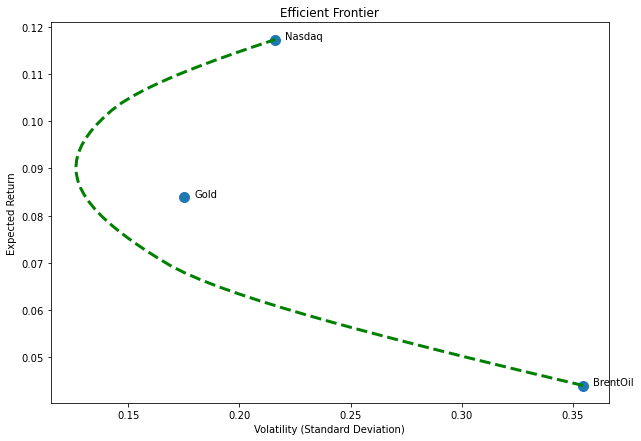

In [15]:
import matplotlib.pyplot as plt

#효율적 투자선 시각화
plt.figure(figsize=(10, 7))
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.plot(frontier_volatility, frontier_returns, 'g--', linewidth=3)
plt.scatter(volatility, expected_returns, marker='o', s=100)

# 그림의 각 자산에 대한 점 주석 달기
for i, txt in enumerate(expected_returns.index):
    plt.annotate(txt, (volatility[i], expected_returns[i]), xytext=(10, 0), textcoords='offset points')

plt.show()

In [16]:
# 최대 기대 수익률을 가진 포트폴리오와 변동성을 최소화한 포트폴리오 찾기

#최대 수익률
max_return_portfolio=efficient_portfolios[np.argmax(frontier_returns)]

#최소 변동성
min_volatility_portfolio=efficient_portfolios[np.argmin(frontier_volatility)]

(max_return_portfolio.x, max_return_portfolio.fun, max_return_portfolio.success), \
(min_volatility_portfolio.x, min_volatility_portfolio.fun, min_volatility_portfolio.success)


((array([1.11022302e-16, 1.92301429e-08, 9.99999981e-01]),
  0.21599346035384698,
  True),
 (array([0.12772751, 0.52490606, 0.34736644]), 0.12644882950329167, True))